In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import sample
from copy import deepcopy

## Step 1
Import data and make some exploratory analysis. Distance is normalized to the average, Population is normalized to the total population

In [2]:
cities = pd.read_csv('cityData.dat', header=None, sep='\t', index_col=0, names=['City', 'Population', 'Latitude', 'Longitude'])
cities.head()

,City,Population,Latitude,Longitude
0,Berlin,0.170716,52.52,13.38
1,Hamburg,0.087981,53.55,10.00
2,Munich,0.067102,48.14,11.58
3,Cologne,0.050797,50.95,6.97
4,Frankfurt,0.033703,50.12,8.68


In [3]:
cities.shape

(40, 4)

In [4]:
distances = pd.read_csv('cityDistances.dat', sep='\t', header= None, names=['Origin','Destiny','Distance'])
distances.head()

,Origin,Destiny,Distance
0,0,1,5.084382
1,0,2,10.082311
2,0,3,9.523469
3,0,4,8.456714
4,0,5,10.201078


In [5]:
distances.shape

(780, 3)

### Step 1.5
Try to define a graph with the data 

In [6]:
Nodes = [(i,cities.to_dict(orient='records')[i]) for i in range(cities.shape[0])]
Edges = [(distances.iloc[i,0],distances.iloc[i,1],{'weight': distances.iloc[i,2]}) for i in range(distances.shape[0])]

In [7]:
print(Nodes[:3])
print(Edges[:3])

[(0, {'City': 'Berlin', 'Population': 0.1707159963294827, 'Latitude': 52.52, 'Longitude': 13.38}), (1, {'City': 'Hamburg', 'Population': 0.0879805435806981, 'Latitude': 53.55, 'Longitude': 10.0}), (2, {'City': 'Munich', 'Population': 0.0671020343799828, 'Latitude': 48.14, 'Longitude': 11.58})]
[(0, 1, {'weight': 5.084381891841052}), (0, 2, {'weight': 10.082311312508343}), (0, 3, {'weight': 9.523468735599538})]


In [8]:
## Possible useful lists for a general graph
# edges = list(graph.edges) # list of tuples
# nodes = list(graph.nodes) 
# weights = [graph.get_edge_data(i[0],i[1],default=0)['weight'] for i in edges]

In [9]:
# This is a preliminary complete graph
G = nx.Graph()
G.add_nodes_from(Nodes)
G.add_edges_from(Edges)

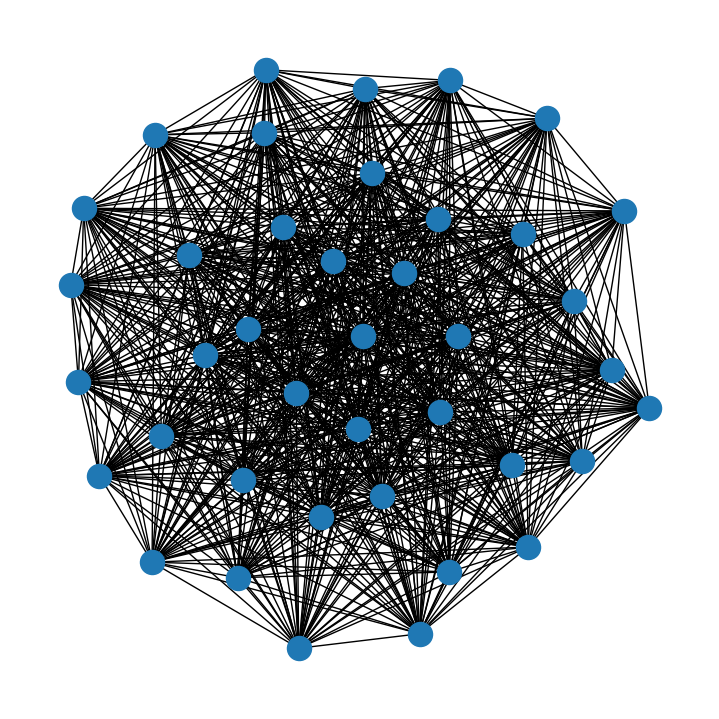

In [10]:
plt.figure(figsize=(7,7))
nx.draw(G)
plt.show()

In [11]:
# p = dict(nx.shortest_path_length(G, weight='weight'))
# [p[0][i] for i in range(cities.shape[0])]

# p = nx.shortest_path_length(G, source=0, target=13, weight='weight')
# p

## Step 2
Define the cost functions
$$C_{tot} = C_{infra} + \gamma C_{trans}$$
$$C_{infra} = \sum_{e_{ij}\in E}d(e_{ij}) $$
$$C_{trans} = \frac{1}{2} \sum_{i,j \in V} P_i P_j ~ \tilde{d}_{ji} $$

Where $ \tilde{d}_{ji}$ is defined by

$$ \tilde{d}(e_{ij}) = (1-\delta) d(e_{ij}) + \delta $$

In [12]:
def C_infra(graph, p= None):
    if p is None:
        p = dict(nx.shortest_path_length(graph, weight='weight'))
    num_nodes = len(graph.nodes)
    sum = 0
    for i in range(num_nodes):
        dist_node = np.sum(list(p[i].values()))
        sum += dist_node
    return sum

In [13]:
def eff_len(δ, graph=G, start=0, end=1, d_ij= None):
    if d_ij is None:
        d_ij = nx.shortest_path_length(graph, source=start, target=end, weight='weight')
    eff_d = (1-δ)*d_ij + δ
    return eff_d

In [14]:
def C_trans(graph, δ, Pop=None, p=None):
    if Pop is None:
        Pop = nx.get_node_attributes(graph,name='Population') # dict with population of each node, for ex: {0: 0.234,...}
    if p is None:
        p = dict(nx.shortest_path_length(graph, weight='weight'))
    num_nodes = len(graph.nodes)
    sum = 0
    for i in range(num_nodes):
        for j in range(num_nodes): 
            if graph.has_edge(i,j):
                sum += Pop[i]*Pop[j]*eff_len(δ,d_ij=p[i][j])
    return 0.5*sum

In [15]:
def C_tot(graph,γ,δ,Pop=None,p=None):
    if Pop is None:
        Pop = nx.get_node_attributes(graph,name='Population') # dict with population of each node, for ex: {0: 0.234,...}
    if p is None:
        p = dict(nx.shortest_path_length(graph, weight='weight'))
    return C_infra(graph,p) + γ*C_trans(graph,δ, Pop, p)

In [16]:
delta= 0.33
gamma = 200

print(C_infra(G)) # This is going to be large, because G is a complete network
print(C_trans(G,delta))
print(C_trans(G,delta)*gamma)
print(C_tot(G,gamma,delta))

8891.94700012232
2.1918727374227065
438.3745474845413
9330.321547606862


## Step 3

Implement the Metropolis algorithm

In [17]:
def Metropolis_step(graph, T, γ, δ):
    # num_nodes = len(graph.nodes)
    link = sample(list(graph.nodes),2)
    
    # Avoid selecting the same node twice
    while link[0] == link[1]:
        link = sample(list(graph.nodes),2)

    dist = distances[(distances['Origin']==link[0]) & (distances['Destiny']==link[1])].iloc[:,2]    # This is inefficient but works
    new_graph = graph.copy()   # This is inefficient, but good for v.1.
    new_graph.add_edge(link[0],link[1],weight=dist)
    
    old_cost = C_tot(graph,γ,δ)
    new_cost = C_tot(new_graph,γ,δ)
    print(old_cost)
    # print(new_cost)
    

In [18]:
# Metropolis_step(G0,1,gamma,delta)
# Metropolis_step(G1,1,gamma,delta)

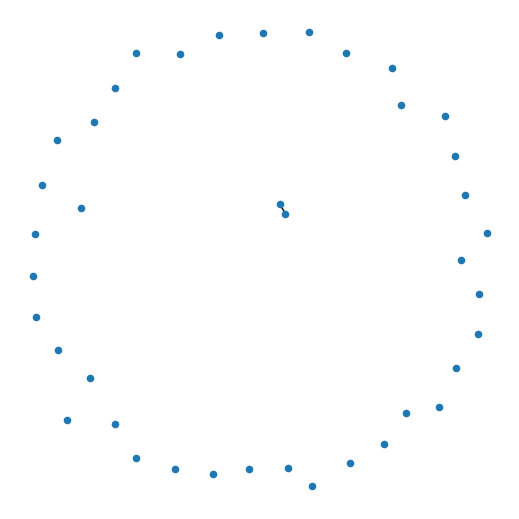

In [19]:
G0 = nx.Graph()
G0.add_nodes_from(Nodes)

G1 = G0.copy()
G1.add_edge(0,5,weight=1.2)

plt.figure(figsize=(5,5))
nx.draw(G1, node_size=20)
plt.show()